In [1]:
import numpy as np
import scipy as sci
import scipy.sparse as spa
import scipy.sparse.linalg as spalg
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

Will solve:

$$\frac{\partial^2 \Phi}{\partial \rho^2} + \frac{1}{\rho} \frac{\partial \Phi}{\partial \rho} +\frac{\partial^2 \Phi}{\partial z^2} = \frac{\partial \Phi}{\partial t} $$

#### As one transitions from cartesian to cylindrical using finite differences, you have to take special care into how you handle your boundary condition at $\rho = 0$ (look at second term in that equation)


#### This means that the second term must be modified for $\rho = 0$. Can be acquired by using L'Hospital's rule at $\rho = 0$

$$\frac{1}{\rho} \frac{\partial \Phi}{\partial \rho} = \frac{\frac{\partial^2 \Phi}{\partial \rho^2}}{1} = \frac{\partial^2 \Phi}{\partial \rho^2} $$

Which leaves you with 

$$2\frac{\partial^2 \Phi}{\partial \rho^2} +\frac{\partial^2 \Phi}{\partial z^2} = \frac{\partial \Phi}{\partial t} \; @ \;\rho  =0$$

#### What does this mean in finite difference land? Well.. this means that:
$$\frac{\partial \Phi}{\partial \rho} = \frac{\Phi_{-1,n}-\Phi_{1,N}}{2\Delta r} = 0 $$
and 
$$\frac{\partial^2 \Phi}{\partial \rho^2} = \frac{2(\Phi_{1,n}-\Phi_{0,N})}{(\Delta r)^2}$$

#### This is the only workaround we need for the COORDINATE CHANGE

#### Now we need to consider BOUNDARY CONDITIONS

#### Stefan has imposed a series of Dirichlet and Neumann boundary conditions that will be noted in more detail once I get a better handle on them

#### For now.. the matrix constucted below is his solution for the laplace operator in cylyndrical:

# Initialize

In [2]:
N = 7
rho_max = .003
drho = rho_max/(N-2)
D = np.zeros(((N-2),(N-2))) 
I = np.eye((N-2),(N-2))
A_deriv1 = np.zeros(((N-2)**2,(N-2)**2))
A_deriv2 = np.zeros(((N-2)**2,(N-2)**2))

## First construct $\frac{1}{\rho} \frac{\partial}{\partial \rho}$

In [3]:
off_diag_down  = np.array([1.0/(2.0*i) for i in range(1,(N-2))])
#off_diag_down[-1] = 0

In [4]:
off_diag_up = np.zeros(off_diag_down.shape)

for i in range(1,(N-3)):
    off_diag_up[i]  = off_diag_up[i] + 1.0/(2.0*i)

In [5]:
off_diag_up

array([0.        , 0.5       , 0.25      , 0.16666667])

In [6]:
on_diag = np.zeros((1,(N-2)))[0]
D_single = D + np.diag(off_diag_up,k=1) + np.diag(-off_diag_down,k=-1) + np.diag(on_diag)
D_single[N-3,:]= 0

In [7]:
D_single

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.5       ,  0.        ,  0.5       ,  0.        ,  0.        ],
       [ 0.        , -0.25      ,  0.        ,  0.25      ,  0.        ],
       [ 0.        ,  0.        , -0.16666667,  0.        ,  0.16666667],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [8]:
D_single = (1/drho)*D_single

In [9]:
print(D_single)

[[   0.            0.            0.            0.            0.        ]
 [-833.33333333    0.          833.33333333    0.            0.        ]
 [   0.         -416.66666667    0.          416.66666667    0.        ]
 [   0.            0.         -277.77777778    0.          277.77777778]
 [   0.            0.            0.            0.            0.        ]]


In [10]:
#for i in np.arange(1,(N-3)):
for i in np.arange(0,(N-2)):
    A_deriv1[i*(N-2):(i+1)*(N-2),i*(N-2):(i+1)*(N-2)] = D_single

## $\frac{\partial^2}{\partial \rho^2} + \frac{\partial^2}{\partial z^2}$

In [26]:
off_diag_up2 = np.ones(off_diag_up.shape)
off_diag_up2[0] = 4

In [27]:
off_diag_down2 = np.ones(off_diag_down.shape)
#off_diag_down2[-1] = 0 

In [28]:
on_diag2 = np.ones(on_diag.shape)*-4
on_diag2[0]= -6
#on_diag2[-1] = 0

In [29]:
on_diag2

array([-6., -4., -4., -4., -4.])

In [30]:
D_double = D + np.diag(off_diag_up2,k=1) + np.diag(off_diag_down2,k=-1) + np.diag(on_diag2)

In [31]:
print(D_double)

[[-6.  4.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.]
 [ 0.  1. -4.  1.  0.]
 [ 0.  0.  1. -4.  1.]
 [ 0.  0.  0.  1. -4.]]


In [32]:
D_double = (1/(drho**2))*D_double
D_double[N-3,:] = 0 
print(D_double)

[[-16666666.66666666  11111111.11111111         0.
          0.                 0.        ]
 [  2777777.77777778 -11111111.11111111   2777777.77777778
          0.                 0.        ]
 [        0.           2777777.77777778 -11111111.11111111
    2777777.77777778         0.        ]
 [        0.                 0.           2777777.77777778
  -11111111.11111111   2777777.77777778]
 [        0.                 0.                 0.
          0.                 0.        ]]


In [33]:
I_deriv2_diag = np.ones(on_diag.shape)
#I_deriv2_diag[-1] = 0

In [34]:
I_deriv2 = np.diag(I_deriv2_diag)

In [35]:
#for i in np.arange(1,(N-3)):
for i in np.arange(1,(N-2)):
    A_deriv2[i*(N-2):(i+1)*(N-2),i*(N-2):(i+1)*(N-2)] = D_double
    
#for i in range(2,N-4):
for i in range(1,N-3):
    A_deriv2[(i*(N-2)):(i*(N-2)+(N-2)),(i*(N-2)-(N-2)):(i*(N-2))] = I_deriv2
    A_deriv2[(i*(N-2)-(N-2)):(i*(N-2)),(i*(N-2)):(i*(N-2)+(N-2))] = I_deriv2

In [36]:
# A_deriv2[0*(N-2):(1)*(N-2),0*(N-2):(1)*(N-2)] = 0

In [37]:
A_deriv2

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
    

In [38]:
A = A_deriv1 + A_deriv2

In [40]:
A_spa = spa.csc_matrix(A)

In [41]:
A_spa

<25x25 sparse matrix of type '<class 'numpy.float64'>'
	with 80 stored elements in Compressed Sparse Column format>

In [42]:
A_det = sci.linalg.det(A)

In [43]:
print(A_det)

0.0


## Boundary Conditions

In [44]:
b = np.zeros(((N-2)*(N-2),1))

In [45]:
b[:(N-2)] = -10000

In [46]:
#b[(N-3)*(N-2):(N-2)*(N-2)] = np.ones(((N-2),1))*-100
#b[0:(N-2)] = np.ones(((N-2),1))*100
for i in range(1,N-1):
    b[(i-1)*(N-2)] = -10000

In [47]:
print(b)

[[-10000.]
 [-10000.]
 [-10000.]
 [-10000.]
 [-10000.]
 [-10000.]
 [     0.]
 [     0.]
 [     0.]
 [     0.]
 [-10000.]
 [     0.]
 [     0.]
 [     0.]
 [     0.]
 [-10000.]
 [     0.]
 [     0.]
 [     0.]
 [     0.]
 [-10000.]
 [     0.]
 [     0.]
 [     0.]
 [     0.]]


In [48]:
b_mat = np.reshape(b,((N-2),(N-2)))

In [49]:
b_mat

array([[-10000., -10000., -10000., -10000., -10000.],
       [-10000.,      0.,      0.,      0.,      0.],
       [-10000.,      0.,      0.,      0.,      0.],
       [-10000.,      0.,      0.,      0.,      0.],
       [-10000.,      0.,      0.,      0.,      0.]])

In [50]:
U = spalg.spsolve(A_spa,b)

/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [51]:
U_mat = np.reshape(U,((N-2),(N-2)))

In [41]:
r = np.arange(0,N-2)
z = np.arange(0,N-2)
R,Z = np.meshgrid(r,z)

/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


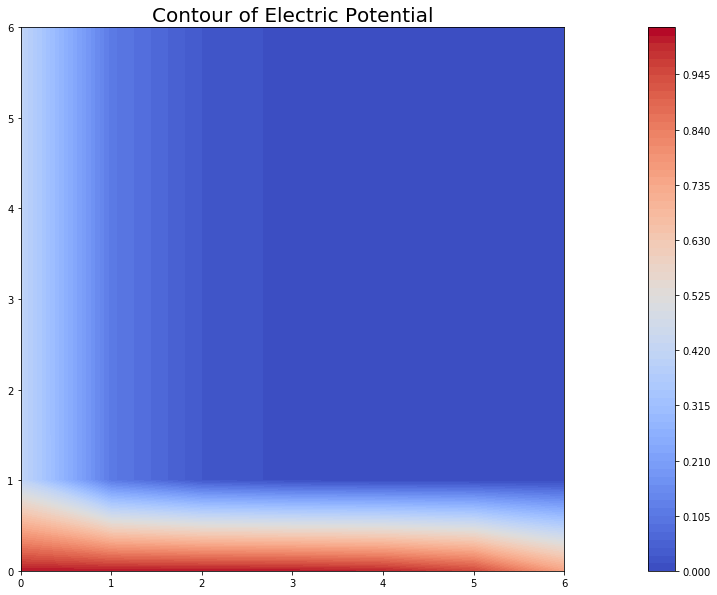

In [42]:
#Set interpolation and colormap
colorinterp = 100
colormap = plt.cm.coolwarm
figure = plt.figure(figsize=(30,10))
plt.contourf(R,Z,U_mat, colorinterp, cmap=colormap)
plt.title("Contour of Electric Potential", fontsize=20)
#Set Colorbar
plt.colorbar()
#Show the result in the plot winow
plt.axes().set_aspect('equal')
plt.show()
print("")